In [1]:
#Import Packages
##Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy.signal import find_peaks

In [2]:
#Get Data
cols = ["frequency", "out_in", "V_out", "V_in"]
raw_data1 = pd.read_csv("DataFiles/Day3_101pf_peak.csv", delimiter="\t", names=cols)
background = pd.read_csv("DataFiles/Gang_4_Pedastal_180sec_Amp150.csv", delimiter="\t", names=cols)


raw_data1

,frequency,out_in,V_out,V_in
NaN,300.000000,0.782683,0.004944,0.003870
NaN,315.985858,0.795632,0.004943,0.003933
NaN,331.979971,0.815142,0.004933,0.004021
NaN,347.968333,0.829092,0.004950,0.004104
NaN,363.957326,0.845377,0.004957,0.004191
...,...,...,...,...
NaN,1914.844387,0.769870,0.004947,0.003808
NaN,1930.828800,0.763114,0.004943,0.003772
NaN,1946.819499,0.750955,0.004954,0.003720
NaN,1962.818373,0.742838,0.004954,0.003680


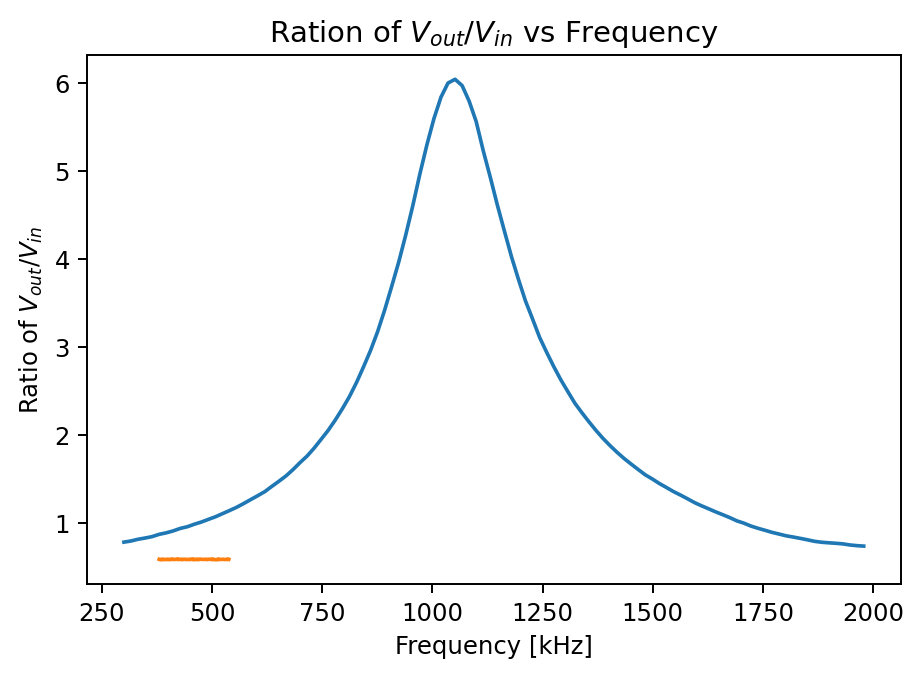

In [3]:
plt.figure(dpi=175)
plt.title("Ration of $V_{out}$/$V_{in}$ vs Frequency")
plt.xlabel("Frequency [kHz]")
plt.ylabel("Ratio of $V_{out}$/$V_{in}$")


plt.plot(raw_data1["frequency"], raw_data1["out_in"] )
plt.plot(background["frequency"], background["out_in"] )

#plt.ylim(0,.05)

#plt.legend()

plt.savefig("Plots/LED_Comparison.pdf")

### Resonance Fitting

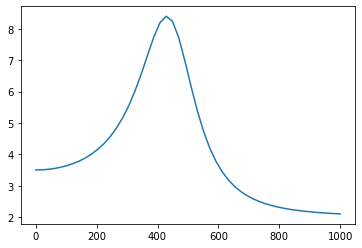

In [6]:
x = np.linspace(0,1000)

plt.plot(x, resonance(x, 3, 2, 460, 2))

[1.53584652e+00 3.38350107e+00 1.09230985e+03 6.82720289e-01]
[0.04433438 0.10414026 3.15502563 0.04788441]
[2.88664152 3.0778845  0.2888398  7.01376747]


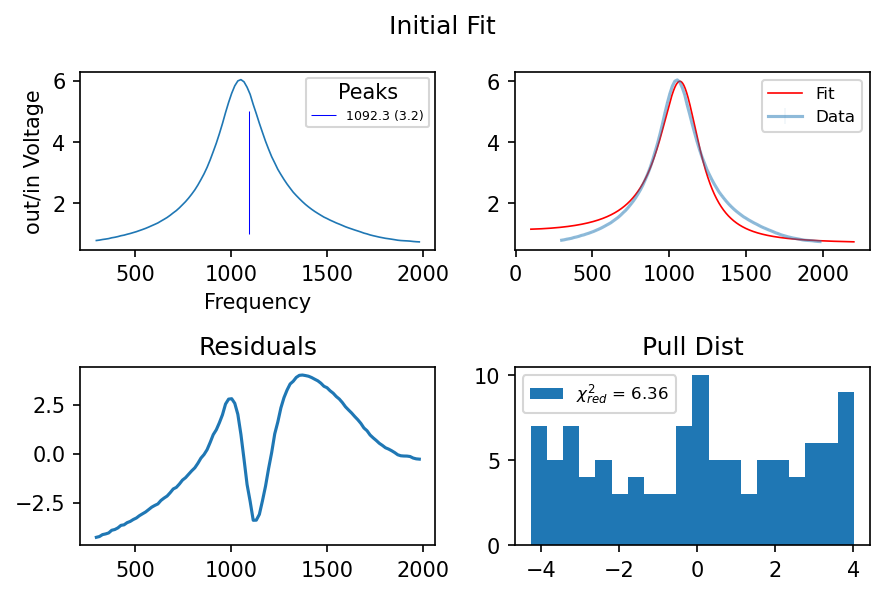

CPU times: user 504 ms, sys: 67 ms, total: 571 ms
Wall time: 595 ms


In [5]:
%%time
def gauss(x,mu=0,sigma=1):
    return np.exp(-((mu-x)**2/(2*(sigma)**2)))

def single_Gauss(x, A,mu1,sig1, d): 
    return A*gauss(x,mu1,sig1) + d

def resonance(x, A,Q,f0, d):
    g=x/f0
    s=(1-g**2)
    D=Q**2*s**2+g**2
    y=A*Q/D + d
    return y

func = resonance

##Get Hist
plt.figure(dpi=150)
plt.suptitle(f"Initial Fit")
plt.subplot(2, 2, 1)
plt.xlabel("Frequency")
plt.ylabel("out/in Voltage")

keeps = raw_data1["frequency"] > -1

frequency = raw_data1["frequency"][keeps]
out_in = raw_data1["out_in"][keeps]

plt.plot(frequency, out_in, lw=.8)

errors = out_in.values*0 + .1

#pars, cov = scipy.optimize.curve_fit(single_Gauss, frequency.values, out_in.values, #maxfev=3*10**5, sigma=errors,
#                                     p0=[3,460,20, 1],
#                                     bounds=([0.01,380,1, 0],
#                                             [5,520,200, 1.5]))
pars, cov = scipy.optimize.curve_fit(func, frequency.values, out_in.values, #maxfev=3*10**5, sigma=errors,
                                     p0=[3,20,1200, 1], #[3,460,20, 1],
                                     #bounds=([0.01,380,1, 0],
                                     #        [5,520,200, 1.5]))
                                    )
#Mean Lines
plt.vlines(pars[-2],1,5, label=f"{pars[-2]:.1f} ({np.sqrt(cov.diagonal())[-2]:.1f})", color="blue", lw=0.5)

plt.legend(title="Peaks", prop={"size":6})

#Plot Fit
plt.subplot(2, 2, 2)
x = np.arange(100,2200,1)
#shows = (np.arange(0,len(wavelength),1)%10 == 0)

plt.errorbar(frequency.values, 
             out_in.values, yerr=errors/10, ms=.2, elinewidth=.1, alpha=0.5, label="Data")
plt.plot(x, func(x, *pars), color="red", lw=.8, label="Fit")
plt.legend(prop={"size":8})
#plt.xscale("log")
#plt.set_xticks(np.arange(300,901,50), minor=1)

print(pars)
print(np.sqrt(cov.diagonal()))
print(np.sqrt(cov.diagonal())/np.abs(pars)*100)

#Residuals
residuals = (out_in.values-func(frequency.values, *pars))/errors
plt.subplot(2, 2, 3)
plt.title("Residuals")
plt.plot(frequency.values, residuals)#, s=1)

#Pull Dist
plt.subplot(2, 2, 4)
plt.title("Pull Dist")
red = "{red}"
plt.hist(residuals, 20, label=f"$\chi_{red}^2$ = {np.sum(residuals**2)/len(residuals):.2f}")
plt.legend(prop={"size":8})

plt.tight_layout()
plt.savefig(f"Plots/Initial_Fit.pdf")
plt.show()